# Simple analysis of representative days using pypsa-eur

In [1]:
from pathlib import Path
import yaml

import pypsa

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import networkx as nx
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA

%matplotlib inline

Load the pypsa network which we are going to analyse.

In [2]:
fig_dir = "../figures"
n = pypsa.Network("../networks/elec_s_100_ec_lcopt_Co2L-1H.nc")

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_Co2L-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Generate a dictionary indexed by days, with each day containing the snapshots of `n` in that day.

In [3]:
days = pd.interval_range(start=n.snapshots[0], end=n.snapshots[-1] + pd.Timedelta('1 days'), freq='1D', closed='left')
snapshots_by_days = {i: [] for i in days}
day_iter = iter(snapshots_by_days)
current_day = next(day_iter)
for s in n.snapshots:
    if s not in current_day:
        current_day = next(day_iter)
    snapshots_by_days[current_day].append(s)

## Cluster analysis using k-means clustering

We want to cluster daily series. So we need to transform a collection of yearly time series and shuffles the data around to get an array of shape (#days, 24 x #series).

In [4]:
def hourly_to_daily(series: pd.Series) -> np.array:
    """Reshape an hourly time series into an array with rows for days and columns for hours."""
    a = series.to_numpy()
    old_shape = a.shape
    new_shape = (int(old_shape[0] / 24), old_shape[1] * 24)
    return a.reshape(new_shape)

Define a function to add up offwind-ac and offwind-dc columns, so we don't have to deal with both separately.

In [5]:
def agg_offwind_ac_dc(gen):
    output = gen
    for ac_wind_gen in filter(lambda c: "offwind-ac" in c, gen.columns):
        dc_wind_gen = ac_wind_gen.replace("-ac", "-dc")
        wind_gen = ac_wind_gen[:-3]
        if dc_wind_gen in n.generators.index:
            output[wind_gen] = gen[ac_wind_gen] + gen[dc_wind_gen]
            output = output.drop(dc_wind_gen, axis='columns')
        else:
            output[wind_gen] = gen[ac_wind_gen]
        output = output.drop(ac_wind_gen, axis='columns')
    return output

Generate normalised time series for load and capacity factors, and combine them to form the input "profile" of the model.

In [6]:
# Get renewable capacity factor time series, aggregate AC and DC offwind and normalise.
gen = n.generators_t['p_max_pu']
gen = agg_offwind_ac_dc(gen)
norm_gen = gen / gen.max()
norm_gen_days = hourly_to_daily(norm_gen)

# Get normalised demand time series. Note that demand series for different nodes in
# the same country will be the same up to scaling, since PyPSA-eur only has
# country-wide demand profiles.
norm_load = n.loads_t['p_set'] / n.loads_t['p_set'].max()
norm_load_days = hourly_to_daily(norm_load)

# Combine everything into a "profile".
norm_profile_days = np.concatenate([norm_gen_days, norm_load_days], axis=1)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Do the same with series only for Norway.

In [7]:
# Get renewable capacity factor time series, aggregate AC and DC offwind and normalise.
gen_no = n.generators_t['p_max_pu'].filter(regex='NO', axis=1)
gen_no = agg_offwind_ac_dc(gen_no)
norm_gen_no = gen_no / gen_no.max()
norm_gen_days_no = hourly_to_daily(norm_gen_no)

# Get normalised demand time series. This is really just one unique time series.
load_no = n.loads_t['p_set'].filter(regex='NO', axis=1)
norm_load_no = load_no / load_no.max()
norm_load_days_no = hourly_to_daily(norm_load_no)

# Combine everything into a "profile".
norm_profile_days_no = np.concatenate([norm_gen_days_no, norm_load_days_no], axis=1)

<ipython-input-5-d77c641c33ea>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Cluster European and Norwegian days (just load and load combined with capacity factors) to a range of different clusters.

Note: the clustering can take a few minutes.

In [8]:
if not Path("../results/inertias.csv").exists():
    # Decide to how many days we want to cluster.
    cluster_numbers = list(range(1, 15)) + [15 * i for i in range(1, 25)] + [365]

    # Prepare the table of clustering inertias, and do the clustering.
    inertias = pd.DataFrame(columns=['Load NO', 'Load + cap. factors NO', 'Load EUR', 'Load + cap. factors EUR'], index=cluster_numbers)
    for c in cluster_numbers:
        inertias.loc[c, 'Load NO'] = KMeans(n_clusters=c, random_state=0).fit(norm_load_days_no).inertia_
        inertias.loc[c, 'Load + cap. factors NO'] = KMeans(n_clusters=c, random_state=0).fit(norm_profile_days_no).inertia_
        inertias.loc[c, 'Load EUR'] = KMeans(n_clusters=c, random_state=0).fit(norm_load_days).inertia_
        inertias.loc[c, 'Load + cap. factors EUR'] = KMeans(n_clusters=c, random_state=0).fit(norm_profile_days).inertia_

    # Export the inertia numbers to a csv file.
    Path("../results").mkdir(exist_ok=True)
    inertias.to_csv("../results/inertias.csv")
else:
    inertias = pd.read_csv("../results/inertias.csv", index_col=0)

Plot the results.

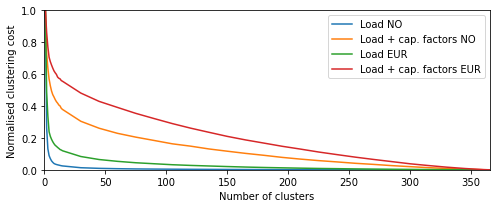

In [9]:
norm_inertias = inertias / inertias.max()
fig, ax = plt.subplots(figsize=(7, 3))
norm_inertias.plot(ax=ax)
ax.set_ylim(bottom=0, top=1)
ax.set_xlim(left=0, right=365)
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Normalised clustering cost")

plt.tight_layout()
fig.savefig(os.path.join(fig_dir, "cluster_inertia_convergence.pdf"))

Summarise how many input time series we are dealing with.

In [10]:
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)
countries = config['countries']

print(f"Number of load series in Norway: 1")
print(f"Number of cap. series in Norway: {len(norm_gen_no.columns)}")
print(f"Number of load series in Europe: {len(countries)}")
print(f"Number of cap. series in Europe: {len(norm_gen.columns)}")

Number of load series in Norway: 1
Number of cap. series in Norway: 9
Number of load series in Europe: 33
Number of cap. series in Europe: 325


Sometimes when clustering using k-means, it can be benificial to project the data down a few dimensions few using principle component analysis. We try this here, but note that the result does not change appreciably.

In [11]:
""" cs = 300
cluster_numbers = list(range(1, 15)) + [15 * i for i in range(1, 25)] + [365]
inertias_pca = pd.DataFrame(columns=['Load', 'Generation', 'Full'], index=cluster_numbers)
for c in cluster_numbers:
    inertias_pca.loc[c, 'Load'] = KMeans(n_clusters=c, random_state=0).fit(PCA(n_components=cs).fit_transform(norm_load_days)).inertia_
    inertias_pca.loc[c, 'Generation'] = KMeans(n_clusters=c, random_state=0).fit(PCA(n_components=cs).fit_transform(norm_gen_days)).inertia_
    inertias_pca.loc[c, 'Full'] = KMeans(n_clusters=c, random_state=0).fit(PCA(n_components=cs).fit_transform(norm_profile_days)).inertia_

norm_inertias_pca = inertias_pca / inertias_pca.max()

fig, ax = plt.subplots(figsize=(10, 8))
norm_inertias_pca.plot(ax=ax)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0, right=365) """

" cs = 300\ncluster_numbers = list(range(1, 15)) + [15 * i for i in range(1, 25)] + [365]\ninertias_pca = pd.DataFrame(columns=['Load', 'Generation', 'Full'], index=cluster_numbers)\nfor c in cluster_numbers:\n    inertias_pca.loc[c, 'Load'] = KMeans(n_clusters=c, random_state=0).fit(PCA(n_components=cs).fit_transform(norm_load_days)).inertia_\n    inertias_pca.loc[c, 'Generation'] = KMeans(n_clusters=c, random_state=0).fit(PCA(n_components=cs).fit_transform(norm_gen_days)).inertia_\n    inertias_pca.loc[c, 'Full'] = KMeans(n_clusters=c, random_state=0).fit(PCA(n_components=cs).fit_transform(norm_profile_days)).inertia_\n\nnorm_inertias_pca = inertias_pca / inertias_pca.max()\n\nfig, ax = plt.subplots(figsize=(10, 8))\nnorm_inertias_pca.plot(ax=ax)\nax.set_ylim(bottom=0)\nax.set_xlim(left=0, right=365) "

## Analysis of distances between days using distance matrix

Define a function computing a distance matrix between days of a time series under the Euclidean distance.

In [12]:
def daily_series_distances(year_series: pd.DataFrame) -> np.array:
    """Output a distance matrix for the given time series.
    
    Specifically, output a 365 x 365 distance matrix giving the Euclidean distance between all the days in the input time series."""
    day_series = []
    for day in days:
        s = year_series.loc[snapshots_by_days[day]]
        s = s.reset_index().drop('snapshot', axis=1)
        s = s.to_numpy()
        day_series.append(s)
    distances = np.zeros(shape=(len(days), len(days)))
    for i in range(len(days)):
        for j in range(i):
            distances[i, j] = abs((day_series[i] - day_series[j]).sum().sum())
            distances[j, i] = distances[i, j]
    return distances


Compute distance matrices for load, capacity factors and their combination, and visualise the results as a colour-graded image.

In [13]:
# Load
D_load = daily_series_distances(n.loads_t['p_set'])

# Capacity factors
# `p_max_pu` are capacity factors, and this network only includes wind and PV generators.
D_cap = daily_series_distances(n.generators_t['p_max_pu'])

# To combine load and capacity factors, normalise loads column-wise (i.e. node-wise).
load_norm = n.loads_t['p_set'] / n.loads_t['p_set'].max()
# Normalise generation capacity factors.
cap_norm = n.generators_t['p_max_pu'] / n.generators_t['p_max_pu'].max()
# Create dataframe of both renewable capacity factor time series and load combined.
profile = pd.concat([cap_norm, load_norm], axis=1)
D_combined = daily_series_distances(profile)

<ipython-input-14-75d782cae417>:21: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



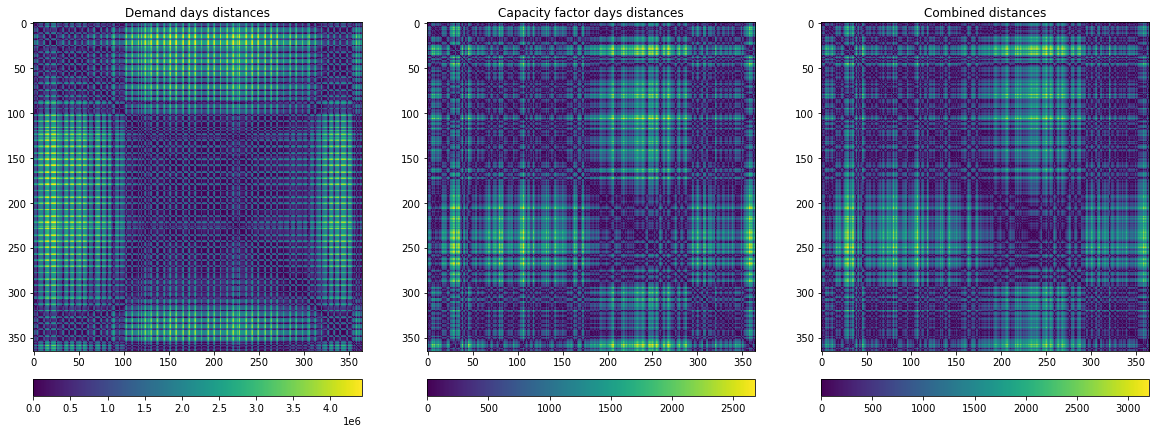

In [14]:
# Visualise the results as images.

fig, axs = plt.subplots(1, 3, figsize=(20, 8))
im = [None] * 3

im[0] = axs[0].imshow(D_load, interpolation='none')
axs[0].set_title("Demand days distances")

im[1] = axs[1].imshow(D_cap, interpolation='none')
axs[1].set_title("Capacity factor days distances")

im[2] = axs[2].imshow(D_combined, interpolation='none')
axs[2].set_title("Combined distances")

for i in range(3):
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes("bottom", size="5%", pad=0.4)
    plt.colorbar(im[i], cax=cax, orientation="horizontal")

fig.savefig(os.path.join(fig_dir, "distances.pdf"))
fig.show()

As we can see from the above, distances between days are largely dominated by renewable capacity factors.